In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

2023-04-04 01:08:31.875173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 01:08:35.095890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u188968/.local/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/vpl/2023.0.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/tbb/2021.8.0/env/../lib/intel64/gcc4.8:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/rkcommon/1.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray_studio/0.11.1/lib

In [2]:
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from IPython.display import HTML
from base64 import b64encode

def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [9]:
NonViolenceVideos_Dir = "Data/nonViolence/"
ViolenceVideos_Dir = "Data/violence/"

NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [7]:
Play_Video(f"{NonViolenceVideos_Dir}/{Random_NonViolence_Video}")

In [10]:
Play_Video(f"{ViolenceVideos_Dir}/{Random_Violence_Video}")

In [11]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 16

DATASET_DIR = "Data/"

CLASSES_LIST = ["nonViolence","violence"]

In [12]:
def frames_extraction(video_path):
 
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        
        if not success:
            break
            
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
        
    video_reader.release()
    
    return frames_list

In [13]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            frames = frames_extraction(video_file_path)
 
            if len(frames) == SEQUENCE_LENGTH:
 
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [14]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: nonViolence


[h264 @ 0x5612b8fb9a00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5612b8fb9a00] error while decoding MB 98 31
[h264 @ 0x5612c73d67c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5612c73d67c0] error while decoding MB 98 31
[h264 @ 0x5612c73d67c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5612c73d67c0] error while decoding MB 98 31
[h264 @ 0x5612c73d67c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5612c73d67c0] error while decoding MB 98 31
[h264 @ 0x5612c73d67c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5612c73d67c0] error while decoding MB 98 31
[ERROR:0@424.571] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.7.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): Data/nonViolence/.ipynb_checkpoints in function 'icvExtractPattern'




Extracting Data of Class: violence


In [15]:
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [16]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [17]:
one_hot_encoded_labels = to_categorical(labels)

In [18]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [19]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(1799, 16, 64, 64, 3) (1799, 2)
(200, 16, 64, 64, 3) (200, 2)


In [20]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False , weights="imagenet")

mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

2023-04-04 01:26:53.116777: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u188968/.local/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/vpl/2023.0.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/tbb/2021.8.0/env/../lib/intel64/gcc4.8:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/rkcommon/1.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray_studio/0.11.1/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/ospray/2.10.0/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/openvkl/1.3.1/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/oidn/1.4.3/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/mpi/2021.8.0//libfabric/lib:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/

In [21]:
def create_model():
 
    model = Sequential()

    
    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    model.summary()
    
    return model

In [22]:
MoBiLSTM_model = create_model()

plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 2, 2, 1280)   2257984   
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 5120)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               1319168   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [23]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 8 ,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/20
180/180 [==============================] - 44s 204ms/step - loss: 0.6942 - accuracy: 0.5191 - val_loss: 0.6808 - val_accuracy: 0.6472 - lr: 0.0100
Epoch 2/20
180/180 [==============================] - 35s 194ms/step - loss: 0.6890 - accuracy: 0.5295 - val_loss: 0.6759 - val_accuracy: 0.6722 - lr: 0.0100
Epoch 3/20
180/180 [==============================] - 35s 195ms/step - loss: 0.6646 - accuracy: 0.6060 - val_loss: 0.6321 - val_accuracy: 0.6889 - lr: 0.0100
Epoch 4/20
180/180 [==============================] - 35s 194ms/step - loss: 0.5645 - accuracy: 0.7408 - val_loss: 0.6189 - val_accuracy: 0.7333 - lr: 0.0100
Epoch 5/20
180/180 [==============================] - 35s 194ms/step - loss: 0.4344 - accuracy: 0.8158 - val_loss: 0.4418 - val_accuracy: 0.8028 - lr: 0.0100
Epoch 6/20
180/180 [==============================] - 35s 195ms/step - loss: 0.3340 - accuracy: 0.8687 - val_loss: 0.7756 - val_accuracy: 0.7528 - lr: 0.0100
Epoch 7/20
180/180 [==============================] 

In [24]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 3s 274ms/step - loss: 0.2348 - accuracy: 0.9250


In [25]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'green', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

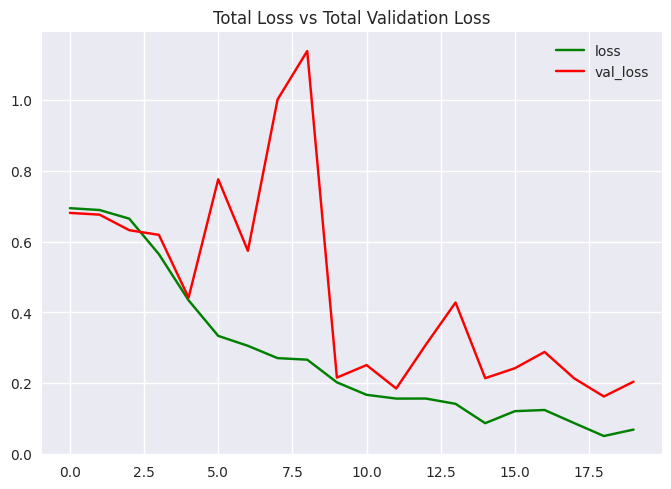

In [26]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

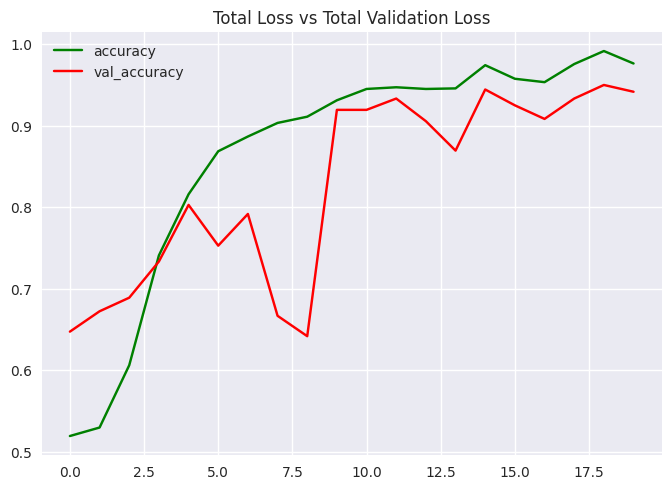

In [27]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [28]:
labels_predict = MoBiLSTM_model.predict(features_test)

labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

labels_test_normal.shape , labels_predict.shape

7/7 [==============================] - 4s 260ms/step


((200,), (200,))

In [29]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)



Accuracy Score is :  0.925


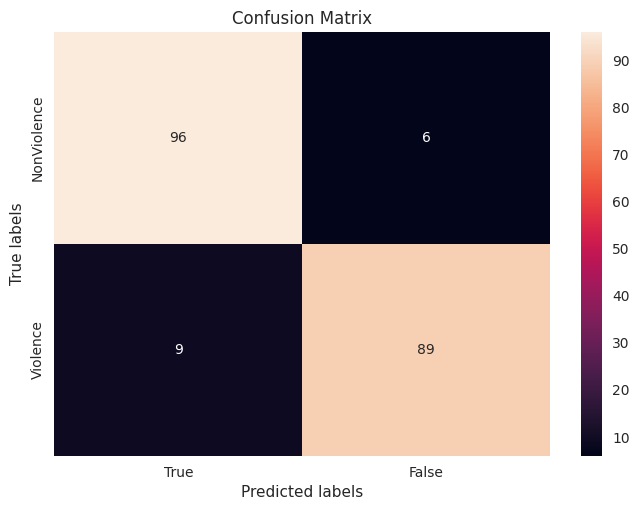

In [30]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [31]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       102
           1       0.94      0.91      0.92        98

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200



In [32]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    
    predicted_class_name = ''
        
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
            
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
    
        if len(frames_queue) == SEQUENCE_LENGTH:
        
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
        
            predicted_label = np.argmax(predicted_labels_probabilities)
        
            predicted_class_name = CLASSES_LIST[predicted_label]
    
        if predicted_class_name == "Violence":
        
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        video_writer.write(frame) 

    video_reader.release()
    video_writer.release()

In [33]:
plt.style.use("default")

def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20,15))
    
    video_reader = cv2.VideoCapture(pred_video_path)
    
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))
    
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        
        ok, frame = video_reader.read()
        
        if not ok:
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        plt.imshow(frame);ax.figure.set_size_inches(20, 20); plt.tight_layout()
        
    video_reader.release()
            

In [34]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 42ms/step


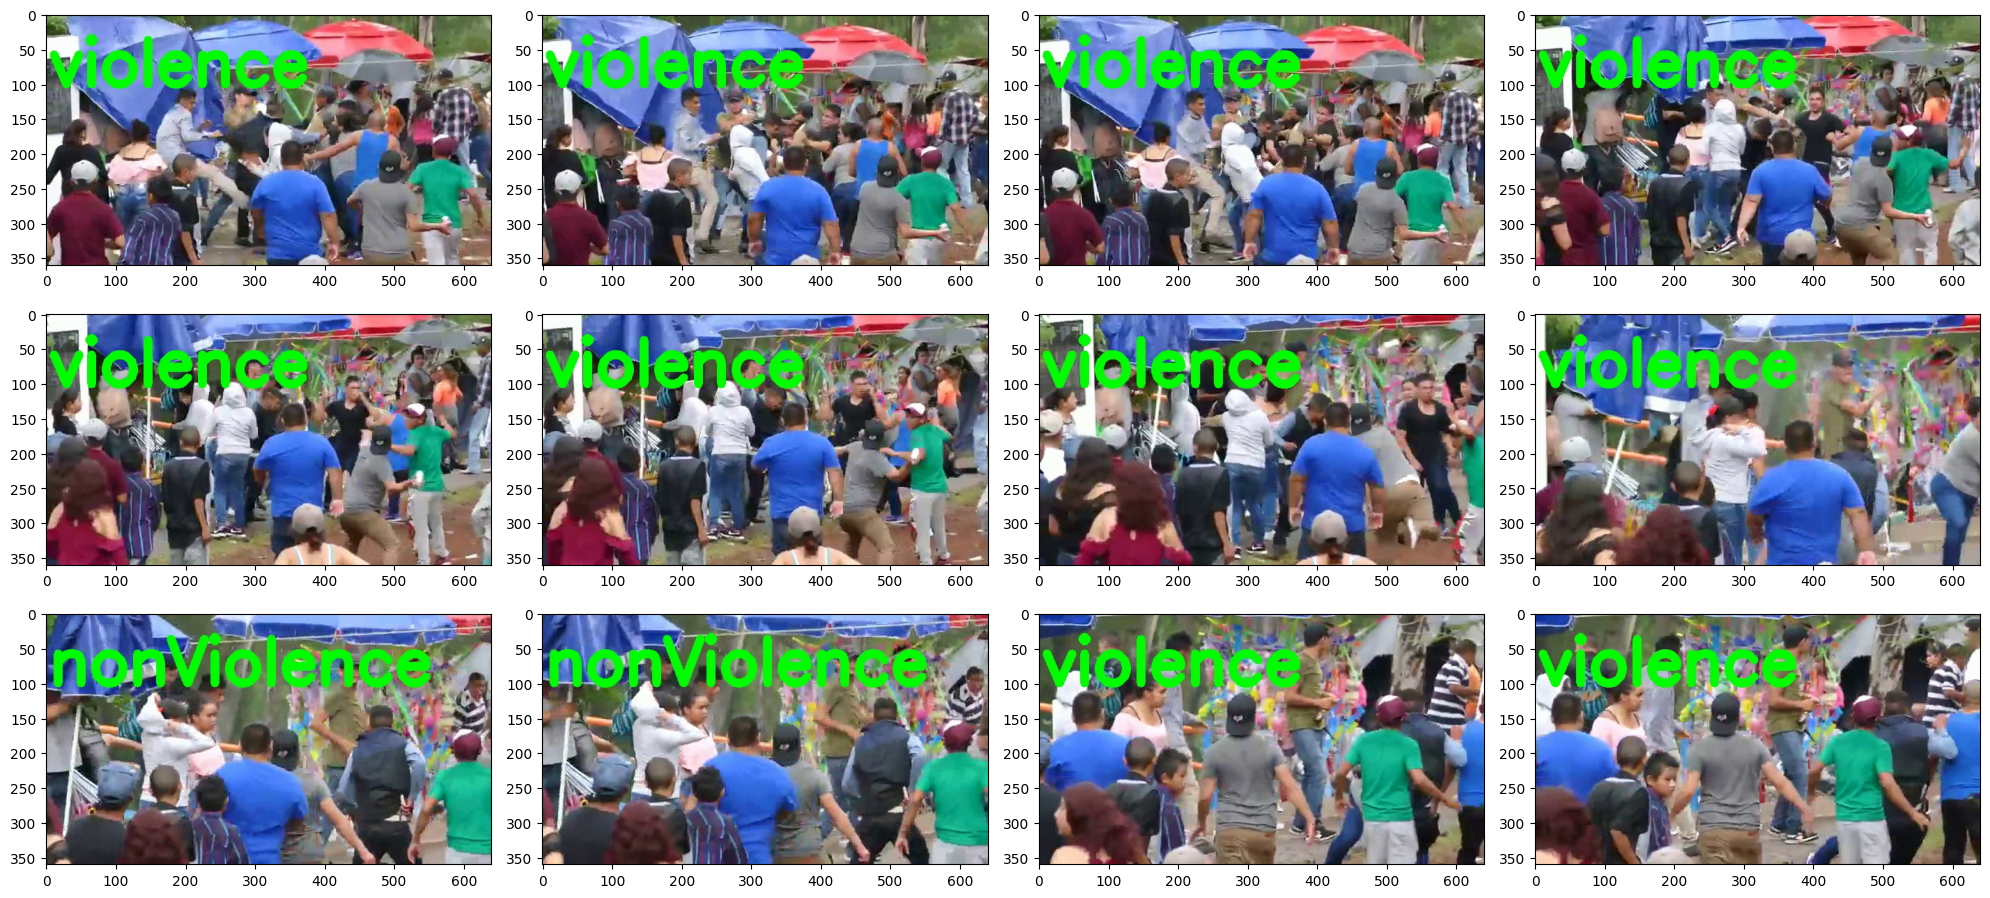

In [35]:
input_video_file_path = "Data/violence/V_628.mp4"

predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

show_pred_frames(output_video_file_path)

In [36]:
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 37ms/step


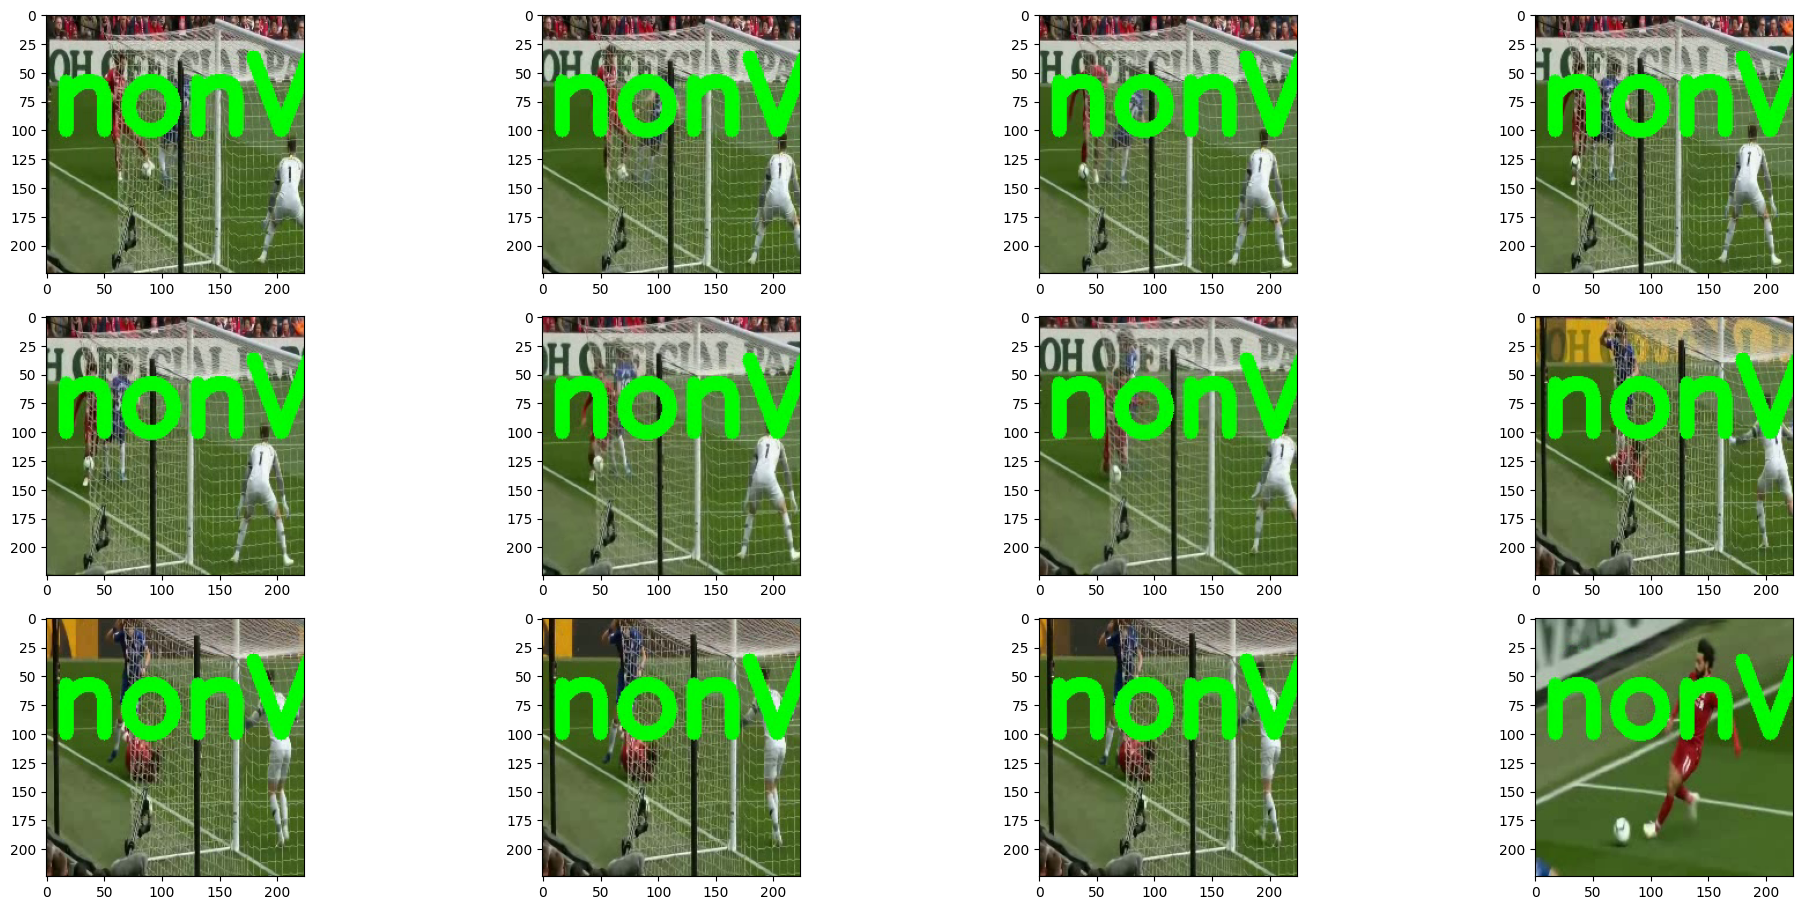

In [37]:
input_video_file_path = "Data/nonViolence/NV_100.mp4"

predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

show_pred_frames(output_video_file_path)